In [1]:
# loading the Montecarlo Raw Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [2]:
# Load the excel data into a pandas dataframe
df1 = pd.read_excel('Montecarlo Raw Data.xlsx', sheet_name='Energy Consumption Raw Data') 
df2 = pd.read_excel('Montecarlo Raw Data.xlsx', sheet_name='Daily Temp Average')
df3 = pd.read_excel('Montecarlo Raw Data.xlsx', sheet_name='Energy Production')

print(df1.head(), df2.head(), df3.head())


        Date  Avg Temp  kWh Delivered to Customer  Month Seasson  \
0 2022-01-01        50                     39.708      1  Winter   
1 2022-01-02        47                     31.517      1  Winter   
2 2022-01-03        27                     39.497      1  Winter   
3 2022-01-04        24                     41.692      1  Winter   
4 2022-01-05        31                     34.216      1  Winter   

   hours of light  
0        9.380556  
1        9.393056  
2        9.406667  
3        9.421111  
4        9.436667      Year  2024-01-21 00:00:00
0  2024                19.44
1  2023                35.96
2  2022                15.88
3  2021                29.25
4  2020                24.38         Date  Week Month  hrs of light  Watts_panel_hrlight  Watts produced  \
0 2023-01-01  Wk01   Jan      9.380556            67.328523      631.578947   
1 2023-01-02  Wk01   Jan      9.393056            22.973299      215.789474   
2 2023-01-03  Wk01   Jan      9.406667             8.952218 

In [3]:
# renaming the 'hours of light column in df1 to hrs of light
df1.rename(columns = {'hours of Light':'hrs of light'}, inplace = True) 
df1.rename(columns = {'Seasson':'Season'}, inplace = True)
print(df1.columns)
print(df2.columns)
print(df3.columns)


Index(['Date', 'Avg Temp', 'kWh Delivered to Customer', 'Month', 'Season',
       'hours of light'],
      dtype='object')
Index(['Year', 2024-01-21 00:00:00], dtype='object')
Index(['Date', 'Week', 'Month', 'hrs of light', 'Watts_panel_hrlight',
       'Watts produced', 'Season', 'Sun raise angle', 'Sun Dawn Angle',
       'Distance To Sun', 'Sun Angle', 'Weather Coded'],
      dtype='object')


In [4]:
# Get statistics from power demand
power_demand_mean = df1['kWh Delivered to Customer'].mean()
power_demand_std = df1['kWh Delivered to Customer'].std()


# get statistics from solar generation
watts_produced_mean = df3['Watts produced'].mean()
watts_produced_std = df3['Watts produced'].std()
solar_generation_mean = df3['Watts_panel_hrlight'].mean()
solar_generation_std = df3['Watts_panel_hrlight'].std()


watts_per_panel_hrlight_mean = df3['Watts_panel_hrlight'].mean()
watts_per_panel_hrlight_std = df3['Watts_panel_hrlight'].std()

# calculating weather variability
weather_variability = df3['Weather Coded'].value_counts(normalize=True).to_dict()

# get hrs_of_light statistics
hrs_of_light_mean = df1['hours of light'].mean()
hrs_of_light_std = df1['hours of light'].std()


print(f'Weather variability: {weather_variability}')
print(f'Hours of light mean: {hrs_of_light_mean}, Hours of light std: {hrs_of_light_std}')
print(f'Power demand mean: {power_demand_mean}, Power demand std: {power_demand_std}')
print(f'Watts produced mean: {watts_produced_mean}, Watts produced std: {watts_produced_std}')
print(f'Solar generation mean: {solar_generation_mean}, Solar generation std: {solar_generation_std}')
print(f'Watts per panel per hour of light mean: {watts_per_panel_hrlight_mean}, Watts per panel per hour of light std: {watts_per_panel_hrlight_std}')

Weather variability: {'Good': 0.32132963988919666, 'Average': 0.29916897506925205, 'Bad': 0.2631578947368421, 'Extreme Bad': 0.05817174515235457, 'Excellent': 0.05817174515235457}
Hours of light mean: 12.218682648401826, Hours of light std: 1.9910343886540398
Power demand mean: 37.00345479452055, Power demand std: 11.750855324550965
Watts produced mean: 973.6898781503262, Watts produced std: 521.9841339097212
Solar generation mean: 76.74597972459313, Solar generation std: 34.86242004578992
Watts per panel per hour of light mean: 76.74597972459313, Watts per panel per hour of light std: 34.86242004578992


## Montecarlo Setting up

In [5]:
# figuring out the factor for each month
mean_power_per_month = df1.groupby('Month')['kWh Delivered to Customer'].mean()
mean_power_per_month = mean_power_per_month.to_dict()
print(mean_power_per_month)

# Need to get the total average for all the months
total_power_demand = df1['kWh Delivered to Customer'].mean()
print(total_power_demand)


{1: 34.9531935483871, 2: 34.827, 3: 36.24677419354839, 4: 32.42856666666667, 5: 35.98170967741935, 6: 29.814733333333333, 7: 54.799741935483866, 8: 53.99070967741935, 9: 41.987899999999996, 10: 34.16309677419355, 11: 28.7148, 12: 25.436548387096774}
37.00345479452055


In [6]:
# We need to get a factor from the average power demand for each month
# We will use this factor to scale the power demand for each month
# This will allow us to simulate the power demand for each month
# based on the average power demand for that month
# The factor is the average power demand for each month divided by the overall average power demand
factor_per_month = df1.groupby('Month')['kWh Delivered to Customer'].mean() / total_power_demand
factor_per_month = factor_per_month.to_dict()
factor_per_month

{1: 0.9445927074237118,
 2: 0.9411823894118437,
 3: 0.9795510823199078,
 4: 0.8763659189862637,
 5: 0.9723878453302556,
 6: 0.8057283704695671,
 7: 1.4809358272027773,
 8: 1.4590721319733169,
 9: 1.1347021577622407,
 10: 0.9232407342476681,
 11: 0.7760032180630894,
 12: 0.6874100953098953}

In [7]:
# unique values in the df3['Weather Coded'] column
df3['Weather Coded'].unique()
weather_variability = df3['Weather Coded'].value_counts(normalize=True).to_dict()
print(weather_variability)
weather_multiplier = {
    'Excellent': 1.1,
    'Good': 0.9,
    'Average': 0.8,
    'Bad': 0.6,
    'Extreme Bad': 0.5,
}
print(weather_multiplier)

{'Good': 0.32132963988919666, 'Average': 0.29916897506925205, 'Bad': 0.2631578947368421, 'Extreme Bad': 0.05817174515235457, 'Excellent': 0.05817174515235457}
{'Excellent': 1.1, 'Good': 0.9, 'Average': 0.8, 'Bad': 0.6, 'Extreme Bad': 0.5}


In [8]:
# Ensure weather probabilities sum to 1
weather_probabilities = np.array(list(weather_variability.values()))
weather_probabilities /= weather_probabilities.sum()
weather_probabilities

array([0.32132964, 0.29916898, 0.26315789, 0.05817175, 0.05817175])

## Montecarlo

In [14]:
## working 

In [15]:
## second try

In [18]:
# Define simulation parameters
num_simulations = 1000  # Iterations
years = 30  # Time Horizon

# Running the Monte Carlo simulation
net_power_results = []
panel_requirements = []
yearly_panel_distributions = []  # Store panels per year
all_panels = []  # To store the final number of panels needed per simulation

# Scale factor to bring panels to a reasonable range (adjust as needed)
SCALE_FACTOR = 0.1  

for sim in range(num_simulations):
    total_power_needed = 0
    total_solar_produced = 0
    yearly_panels_required = []  # per year panels

    for year in range(years):
        yearly_power_needed = 0
        yearly_solar_produced = 0
        
        for month in range(1, 13):
            # Simulate power demand per month
            base_demand = np.random.normal(power_demand_mean, power_demand_std)
            month_adjusted_demand = base_demand * factor_per_month[month]  
            demand = max(0, month_adjusted_demand)
            yearly_power_needed += demand
            
            # Simulate sunlight hours for the month
            monthly_hrs_of_light = np.random.normal(hrs_of_light_mean, hrs_of_light_std)
            monthly_hrs_of_light = max(0, monthly_hrs_of_light)
            
            # Panel efficiency
            panel_efficiency = np.random.normal(watts_per_panel_hrlight_mean, watts_per_panel_hrlight_std)
            panel_efficiency = max(0, panel_efficiency)

            # Simulate weather effect
            weather_effect = np.random.choice(list(weather_variability.keys()), p=list(weather_variability.values()))
            weather_base = weather_multiplier[weather_effect]
            weather_multiplier_effect = max(0.1, min(1.2, weather_base * np.random.normal(1, 0.08)))
            
            # Option 1: Scale the panel efficiency up (this simulates more efficient panels)
            scaled_panel_efficiency = panel_efficiency / SCALE_FACTOR
            
            # Compute monthly energy production per panel (in kWh)
            monthly_panel_production = (scaled_panel_efficiency * monthly_hrs_of_light * weather_multiplier_effect * factor_per_month[month]) / 1000
            
            # Option 2 could scale down to the power needed
            # scaled_demand = demand * SCALE_FACTOR
            # yearly_power_needed += scaled_demand
            
            yearly_solar_produced += monthly_panel_production

        # Calculate panels needed for this year
        if yearly_power_needed > 0 and yearly_solar_produced > 0:
            # Calculate raw panel needs without ceiling yet
            raw_panels_needed = (yearly_power_needed * 1.1) / yearly_solar_produced
            
            # Add installation factors for variability
            installation_factor = np.random.normal(1, 0.15)
            
            # Calculate final panel count
            panels_needed = max(1, np.ceil(raw_panels_needed * installation_factor))
            
            # Option 3 Directly scale the final panel count
            # panels_needed = max(1, np.ceil(raw_panels_needed * installation_factor * SCALE_FACTOR))
        else:
            panels_needed = 1
            
        yearly_panels_required.append(panels_needed)
    
    # Using a weighted approach for final panel count
    sorted_yearly = np.sort(yearly_panels_required)
    if len(sorted_yearly) > 0:
        percentile_90 = sorted_yearly[min(int(0.9 * len(sorted_yearly)), len(sorted_yearly)-1)]
        percentile_75 = sorted_yearly[min(int(0.75 * len(sorted_yearly)), len(sorted_yearly)-1)]
    else:
        percentile_90 = percentile_75 = 1
    
    weighted_panel_count = (0.5 * max(yearly_panels_required) + 0.3 * percentile_90 + 0.2 * percentile_75)
    
    # Add final variability factors
    final_variability = np.random.normal(1, 0.12)
    final_panel_count = max(1, np.ceil(weighted_panel_count * final_variability))
    
    all_panels.append(final_panel_count)
    yearly_panel_distributions.append(yearly_panels_required)

# Convert to numpy arrays for easier analysis
all_panels = np.array(all_panels)
yearly_panel_distributions = np.array(yearly_panel_distributions)

Mean panels required: 9.17
Median panels required: 9.00
Standard deviation: 1.25
Min panels required: 6.0
Max panels required: 14.0
90th percentile: 11.0
Estimated 95% Confidence Interval: 7.00 - 12.00


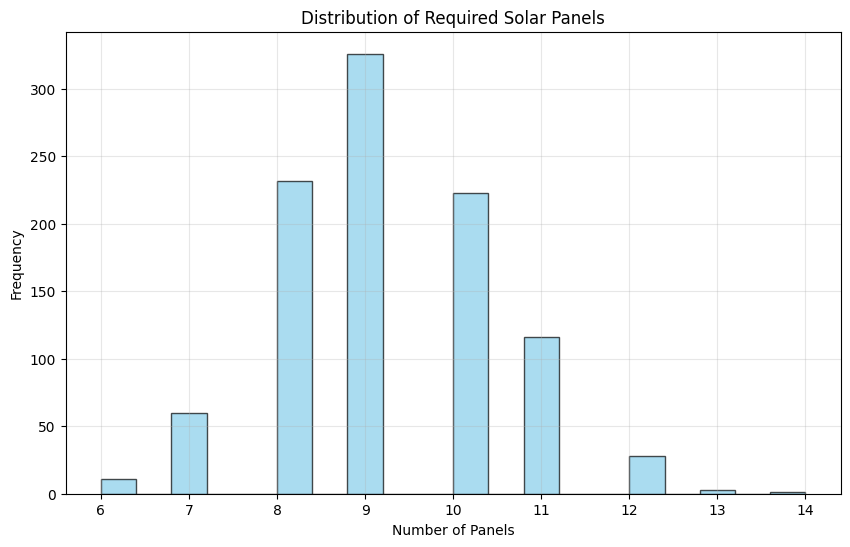

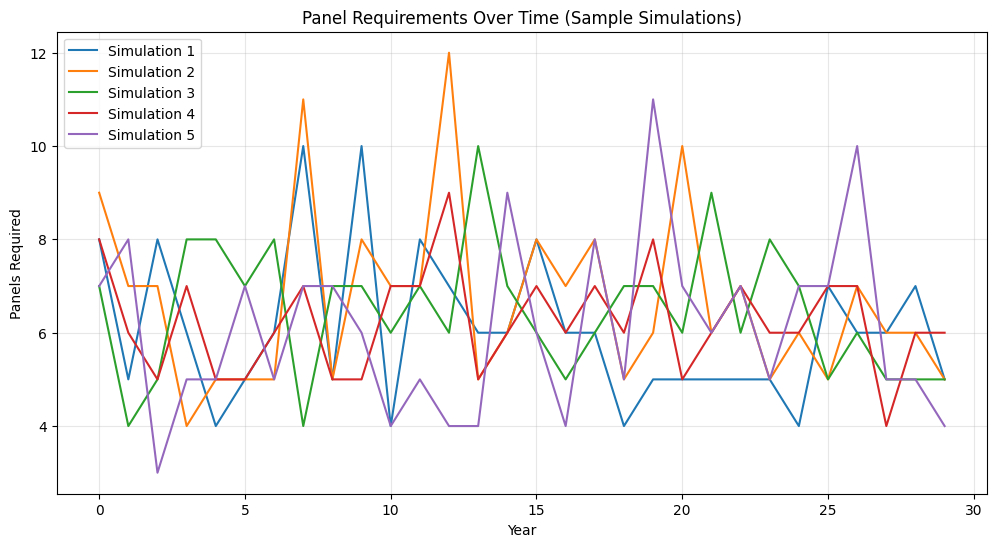

In [19]:
# Now you can analyze the distribution of panel requirements
print(f"Mean panels required: {np.mean(all_panels):.2f}")
print(f"Median panels required: {np.median(all_panels):.2f}")
print(f"Standard deviation: {np.std(all_panels):.2f}")
print(f"Min panels required: {np.min(all_panels)}")
print(f"Max panels required: {np.max(all_panels)}")
print(f"90th percentile: {np.percentile(all_panels, 90)}")
print(f'Estimated 95% Confidence Interval: {np.percentile(all_panels,2.5):.2f} - {np.percentile(all_panels,97.5):.2f}')

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(all_panels, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Required Solar Panels')
plt.xlabel('Number of Panels')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()

# Visualize yearly panel requirement over time for a few simulations
plt.figure(figsize=(12, 6))
for i in range(5):  # Show 5 sample simulation paths
    plt.plot(range(years), yearly_panel_distributions[i], label=f'Simulation {i+1}')
plt.title('Panel Requirements Over Time (Sample Simulations)')
plt.xlabel('Year')
plt.ylabel('Panels Required')
plt.legend()
plt.grid(alpha=0.3)
plt.show()